# Import & summarize data

### Notebook References
- https://www.kaggle.com/kabure/insightful-eda-modeling-lgbm-hyperopt#Scaling-the-target
- https://www.kaggle.com/danofer/baseline-feature-engineering-geotab-69-5-lb

In [3]:
import pandas as pd
import numpy as np
import scipy.stats

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

sns.set()

In [4]:
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')

In [5]:
print("Train dataset shape: "+ str(train.shape))
print("Test dataset shape:  "+ str(test.shape))

Train dataset shape: (857409, 28)
Test dataset shape:  (1920335, 13)


In [6]:
def summarize(df, quant=False):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['name'] = summary['index']
    summary = summary[['name','dtypes']]
    summary['missing'] = df.isnull().sum().values    
    summary['unique'] = df.nunique().values
    summary['first_val'] = df.loc[0].values
    summary['last_val'] = df.loc[len(df)-1].values
    if quant:
        summary['max'] = df.max().values
        summary['mean'] = df.mean().values
        summary['median'] = df.median().values
        summary['stdev'] = df.std().values
    for name in summary['name'].value_counts().index:
        summary.loc[summary['name'] == name, 'entropy'] = round(scipy.stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    return summary

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

def combine_df(df):
    combined = []
    for x in df:
        combined+=(list(df[x].values))
    return combined

<h1>Feature EDA</h1>

In [7]:
train_summary = summarize(train)
test_summary = summarize(test)

In [8]:
predictors = train_summary[12:27]
train_v_test = pd.merge(train_summary,test_summary, on='name',suffixes=('_train','_test'))
train_v_test[['name', 'dtypes_train', 'missing_train', 'missing_test','unique_train','unique_test',
       'first_val_train', 'first_val_test', 'last_val_train', 'last_val_test', 'entropy_train', 'entropy_test']]

,name,dtypes_train,missing_train,missing_test,unique_train,unique_test,first_val_train,first_val_test,last_val_train,last_val_test,entropy_train,entropy_test
0,RowId,int64,0,0,857409,1920335,1920335,0,2777743,1920334,19.71,20.87
1,IntersectionId,int64,0,0,2539,2768,0,1,1990,1990,10.63,10.85
2,Latitude,float64,0,0,4505,5613,33.7917,33.7509,39.9382,39.9382,11.41,11.84
3,Longitude,float64,0,0,4541,5614,-84.43,-84.393,-75.1499,-75.1499,11.43,11.86
4,EntryStreetName,object,8189,19157,1707,2136,Marietta Boulevard Northwest,Peachtree Street Southwest,South 4th Street,South 4th Street,8.97,9.19
5,ExitStreetName,object,5534,16340,1693,2117,Marietta Boulevard Northwest,Mitchell Street Southwest,South 4th Street,South 4th Street,8.95,9.17
6,EntryHeading,object,0,0,8,8,NW,SW,S,S,2.85,2.90
7,ExitHeading,object,0,0,8,8,NW,SE,S,S,2.85,2.90
8,Hour,int64,0,0,24,24,0,0,23,22,4.50,4.49
9,Weekend,int64,0,0,2,2,0,0,1,1,0.85,0.84


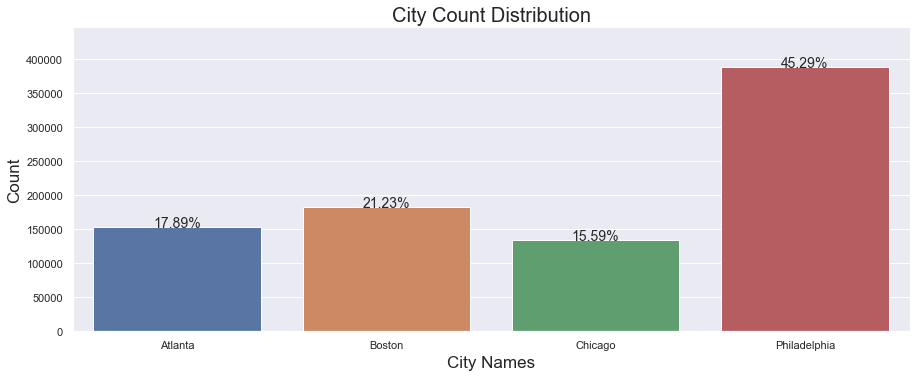

In [9]:
total = len(train)
plt.figure(figsize=(15,19))

plt.subplot(311)
g = sns.countplot(x="City", data=train)
g.set_title("City Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("City Names", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

<ul><li>highest is Philly</li><li>lowest is Chi</li></ul>

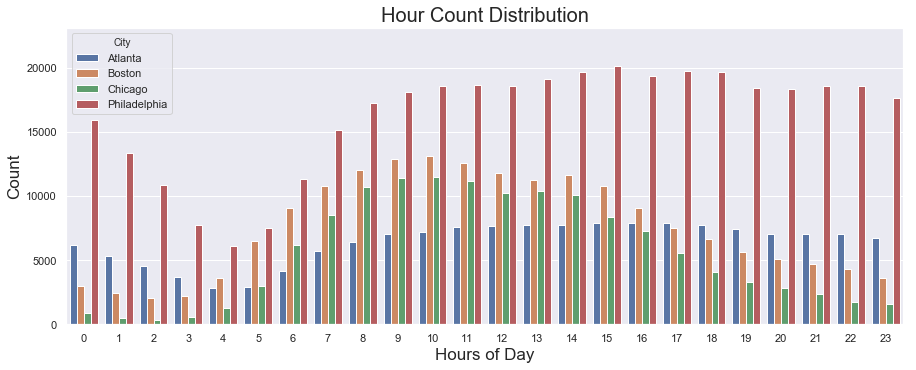

In [10]:
tmp_hour = train.groupby(['City', 'Hour'])['RowId'].nunique().reset_index()

plt.figure(figsize=(15,12))

plt.subplot(211)
g = sns.countplot(x="Hour", data=train, hue='City', dodge=True)
g.set_title("Hour Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Hours of Day", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)
plt.show()

<ul><li>Philly consistently highesat hours, drops off between 1 and 6am</li>
    <li>Atlanta has a similar pattern, but lower overall</li>
    <li>Boston peaks most in the morning and slightly around 2pm</li>
    <li>Chicago follows a similar pattern but is lower overall</li></ul>

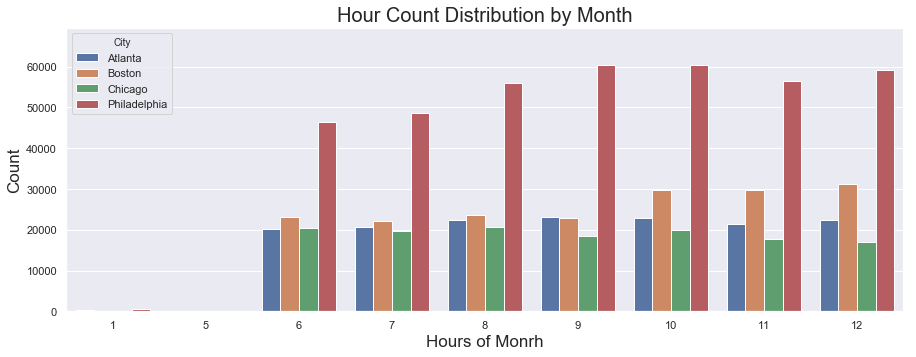

In [11]:
plt.figure(figsize=(15,12))

plt.subplot(212)
g1 = sns.countplot(x="Month", data=train, hue='City', dodge=True)
g1.set_title("Hour Count Distribution by Month", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Hours of Monrh", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

g1.set_ylim(0, max(sizes) * 1.15)

plt.subplots_adjust(hspace = 0.3)

plt.show()

<ul>
<li>only 7 months of data (June - December)</li>
<li>May and Jan exist also but barely any data</li>
<li>Boston steadily rises, rest stay pretty stable</li>
</ul>

In [12]:
percent_weekend = sum(train.Weekend)/len(train.Weekend)
percent_weekday = (1-percent_weekend)
print('Weekend Percent:\t',round(percent_weekend*100,2),
      '%',' (',round((2/7)*100,2),'%)',
      '\nWeekday Percent:\t',round(percent_weekday*100,2),
      '%',' (',round((5/7)*100,2),'%)')

Weekend Percent:	 27.75 %  ( 28.57 %) 
Weekday Percent:	 72.25 %  ( 71.43 %)


<ul>
<li>Percentage of weekend vs weekday data is pretty much as expected</li>
<li>Slightly higher weekday percent but doesn't seem significant</li>    
</ul>

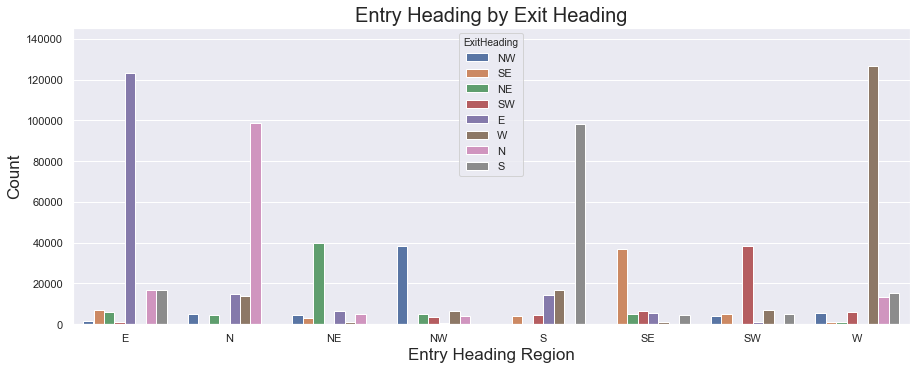

In [13]:
#need to explore entry exit street data
plt.figure(figsize=(15,12))

tmp = round(((train.groupby(['EntryHeading'])['RowId'].nunique() / total) * 100)).reset_index()

plt.subplot(211)
g = sns.countplot(x="EntryHeading",
                  data=train,
                  order=list(tmp['EntryHeading'].values),
                  hue='ExitHeading', dodge=True)
g.set_title("Entry Heading by Exit Heading", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Entry Heading Region", fontsize=17)

sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)
plt.show()

<ul>
<li>biggest take away from this is that most people go straight through intersections</li>
<li>it also seems there is higher travel east/west compared to north/south</li>
</ul>

In [14]:
plt.figure(figsize=(15,12))
plt.subplot(212)
g1 = sns.countplot(x="EntryHeading", order=['E', 'W', 'N', 'S', 'NE', 'NW', 'SE', 'SW'], 
                   data=train, hue='City')
g1.set_title("Entry Heading Distribution By Cities", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Entry Heading Region", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

<ul>
    <li>direction by city shows similar finds as above although some differences</li>
    <li>chicago and atlanta seem pretty evenly distributed across the main directions</li>
    <li>philly and boston are more heavily east/west than north/south cities</li>
    <li>phillh and boston also have much more secondary direction travel compared to atlanta and chicago</li>
</ul>

In [59]:
"""
import folium
from folium.plugins import HeatMap

trafficdf=Atlanda.groupby(['Latitude','Longitude'])['TotalTimeStopped_p20'].count()
trafficdf=trafficdf.to_frame()
trafficdf.columns.values[0]='count1'
trafficdf=trafficdf.reset_index()
lats=trafficdf[['Latitude','Longitude','count1']].values.tolist()
    
hmap = folium.Map(location=[min(Atlanda['Latitude']),min(Atlanda['Longitude'])], zoom_start=10, )
hmap.add_child(HeatMap(lats, radius = 5))
hmap
"""

"\nimport folium\nfrom folium.plugins import HeatMap\n\ntrafficdf=Atlanda.groupby(['Latitude','Longitude'])['TotalTimeStopped_p20'].count()\ntrafficdf=trafficdf.to_frame()\ntrafficdf.columns.values[0]='count1'\ntrafficdf=trafficdf.reset_index()\nlats=trafficdf[['Latitude','Longitude','count1']].values.tolist()\n    \nhmap = folium.Map(location=[min(Atlanda['Latitude']),min(Atlanda['Longitude'])], zoom_start=10, )\nhmap.add_child(HeatMap(lats, radius = 5))\nhmap\n"

- activity heatmap of Atlanta

<h1>Target EDA</h1>

In [15]:
targets = train.iloc[:,12:27]
summarize(targets,True).drop(['first_val','last_val'], axis =1)

,name,dtypes,missing,unique,max,mean,median,stdev,entropy
0,TotalTimeStopped_p20,int64,0,172,273.0,1.731272,0.0,7.080017,0.92
1,TotalTimeStopped_p40,int64,0,234,318.0,5.356027,0.0,12.861420,2.11
2,TotalTimeStopped_p50,int64,0,264,343.0,7.681874,0.0,15.553418,2.70
3,TotalTimeStopped_p60,int64,0,311,368.0,11.905296,0.0,19.631821,3.55
4,TotalTimeStopped_p80,int64,0,403,689.0,22.948071,16.0,28.118134,5.06
5,TimeFromFirstStop_p20,int64,0,239,334.0,3.126932,0.0,11.631092,0.98
6,TimeFromFirstStop_p40,int64,0,306,347.0,9.051338,0.0,20.120829,2.25
7,TimeFromFirstStop_p50,int64,0,329,355.0,12.613628,0.0,23.847749,2.87
8,TimeFromFirstStop_p60,int64,0,351,358.0,18.801785,0.0,29.399634,3.77
9,TimeFromFirstStop_p80,int64,0,355,359.0,34.037097,27.0,40.619387,5.35


In [16]:
#split up for individual distrivution analysis
total_time = targets[['TotalTimeStopped_p20','TotalTimeStopped_p50', 'TotalTimeStopped_p80']]
distance_to_first = targets[['DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']]

#optional
time_from_first = targets[['TimeFromFirstStop_p20','TimeFromFirstStop_p50','TimeFromFirstStop_p80']]

In [17]:
#combine distribution data into a single array
tt_all = combine_df(total_time)
tff_all = combine_df(time_from_first)
dtf_all = combine_df(distance_to_first)

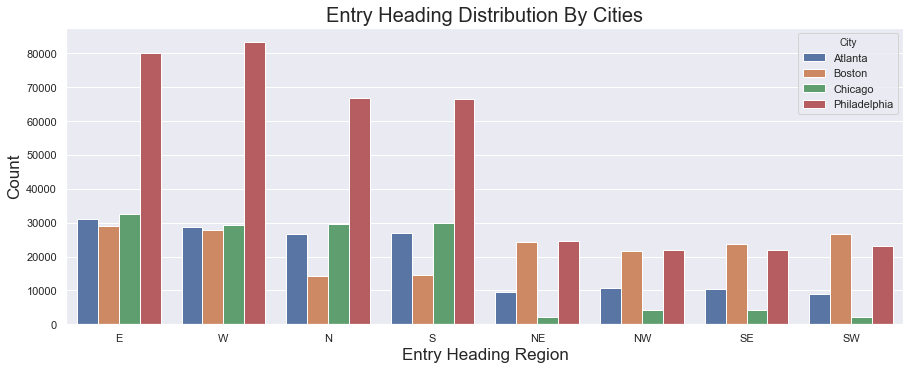

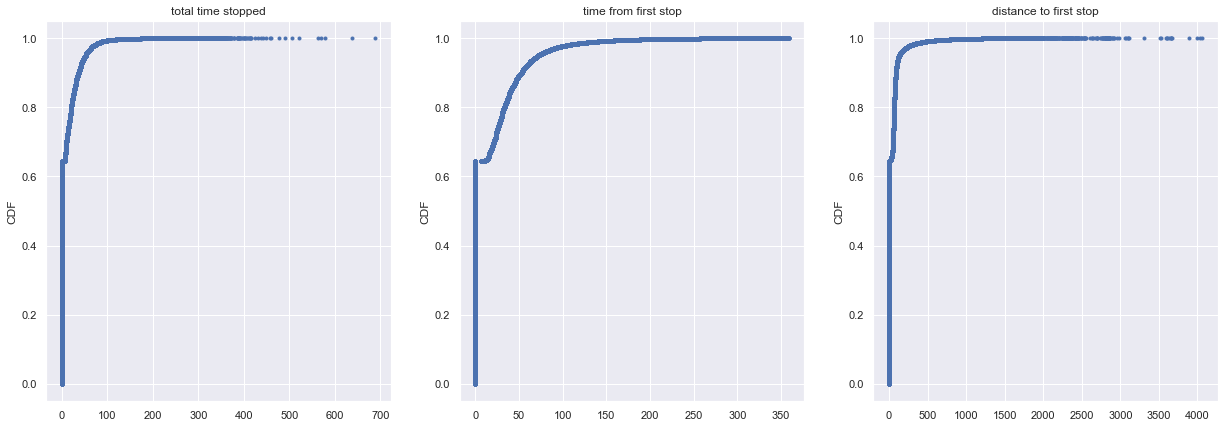

In [18]:
plt.figure(figsize=(21,7))

#tts
x,y=ecdf(tt_all)
plt.subplot(1,3,1)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('total time stopped')
plt.ylabel('CDF')

#tffs
x,y=ecdf(tff_all)
plt.subplot(1,3,2)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('time from first stop')
plt.ylabel('CDF')

#dfs
x,y=ecdf(dtf_all)
plt.subplot(1,3,3)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('distance to first stop')
plt.ylabel('CDF')

plt.show()

<ul>
    <li>distributions of combined data, shows similarity between total time stopeed and distance</li>
</ul>

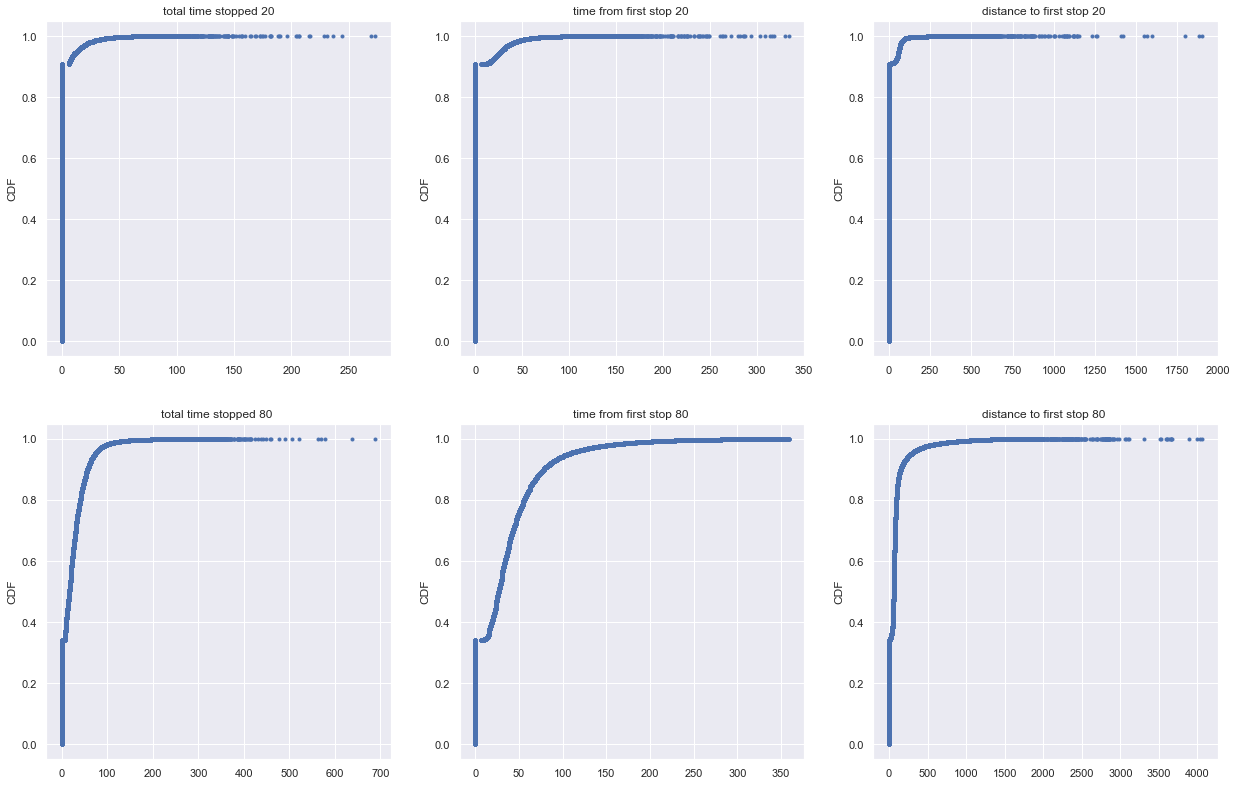

In [19]:
plt.figure(figsize=(21,21))

#tts
x,y=ecdf(total_time.TotalTimeStopped_p20)
plt.subplot(3,3,1)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('total time stopped 20')
plt.ylabel('CDF')

#tffs
x,y=ecdf(time_from_first.TimeFromFirstStop_p20)
plt.subplot(3,3,2)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('time from first stop 20 ')
plt.ylabel('CDF')

#dfs
x,y=ecdf(distance_to_first.DistanceToFirstStop_p20)
plt.subplot(3,3,3)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('distance to first stop 20 ')
plt.ylabel('CDF')

######################################################################
#tts
x,y=ecdf(total_time.TotalTimeStopped_p80)
plt.subplot(3,3,4)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('total time stopped 80 ')
plt.ylabel('CDF')

#tffs
x,y=ecdf(time_from_first.TimeFromFirstStop_p80)
plt.subplot(3,3,5)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('time from first stop 80 ')
plt.ylabel('CDF')

#dfs
x,y=ecdf(distance_to_first.DistanceToFirstStop_p80)
plt.subplot(3,3,6)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('distance to first stop 80 ')
plt.ylabel('CDF')

######################################################################
# #tts
# x,y=ecdf(tt_all)
# plt.subplot(3,3,7)
# plt.plot(x,y,linestyle='none', marker='.')
# plt.title('total time stopped')
# plt.ylabel('CDF')

# #tffs
# x,y=ecdf(tff_all)
# plt.subplot(3,3,8)
# plt.plot(x,y,linestyle='none', marker='.')
# plt.title('time from first stop')
# plt.ylabel('CDF')

# #dfs
# x,y=ecdf(dtf_all)
# plt.subplot(3,3,9)
# plt.plot(x,y,linestyle='none', marker='.')
# plt.title('distance to first stop')
# plt.ylabel('CDF')

plt.show()

<ul>
    <li>time from first and distance to first more similar at p20</li>
    <li>total time stopped similar at p80</li>
</ul>

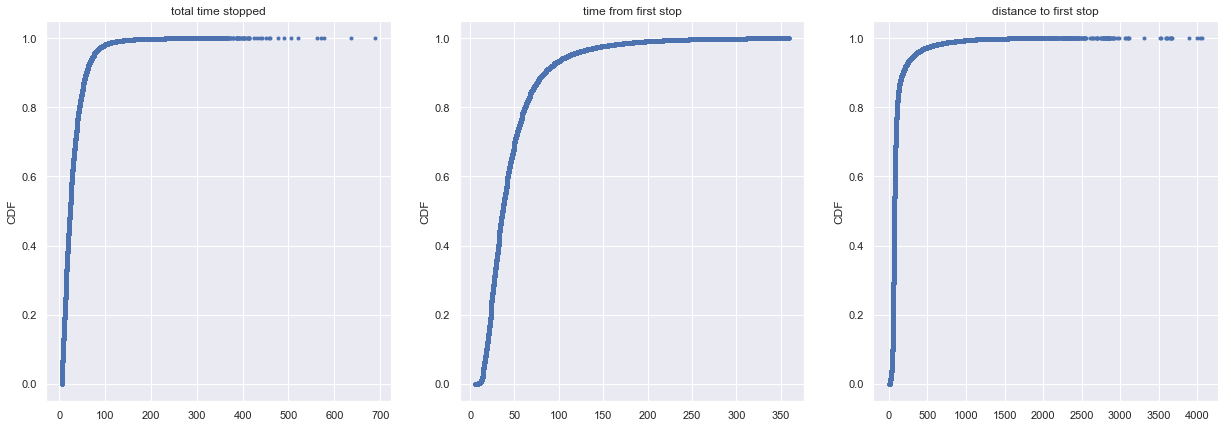

In [20]:
plt.figure(figsize=(21,7))

tt_all_no_zero = []
tff_all_no_zero = []
dtf_all_no_zero = []

for x in tt_all:
    if x !=0: tt_all_no_zero.append(x)
    
for x in tff_all:
    if x !=0: tff_all_no_zero.append(x)
    
for x in dtf_all:
    if x !=0: dtf_all_no_zero.append(x)

#tts
x,y=ecdf(tt_all_no_zero)
plt.subplot(1,3,1)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('total time stopped')
plt.ylabel('CDF')

#tffs
x,y=ecdf(tff_all_no_zero)
plt.subplot(1,3,2)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('time from first stop')
plt.ylabel('CDF')

#dfs
x,y=ecdf(dtf_all_no_zero)
plt.subplot(1,3,3)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('distance to first stop')
plt.ylabel('CDF')

plt.show()

<ul>
<li>looks exponential</li>
</ul>

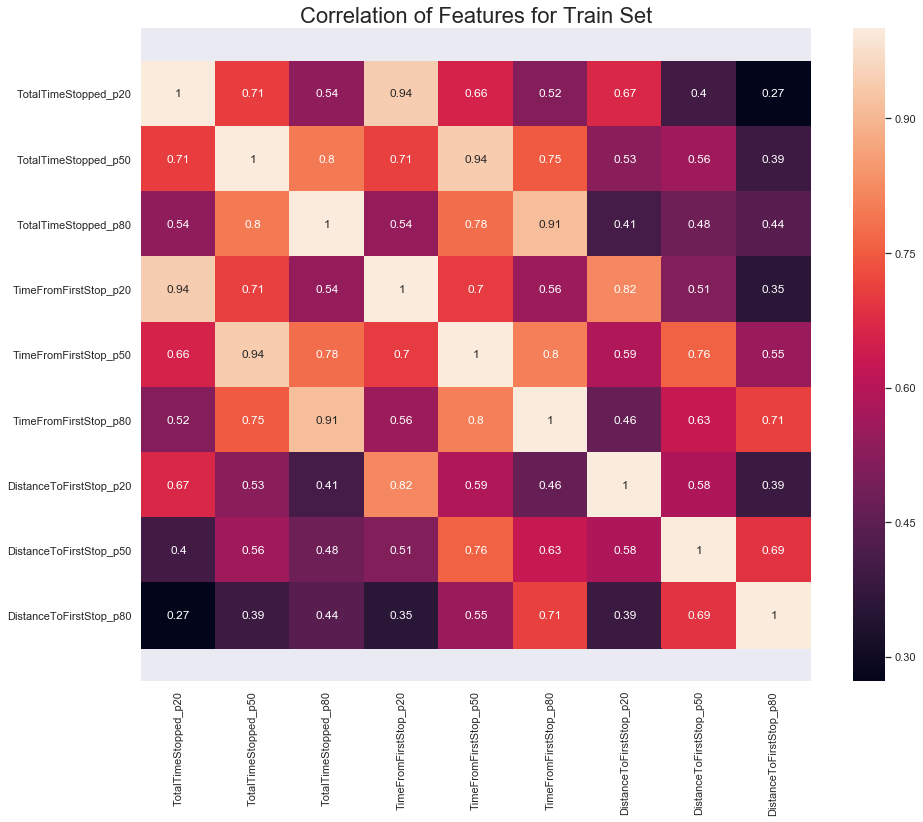

In [21]:
# Checking correlations for metric percentiles
plt.figure(figsize=(15,12))
sns.heatmap(train[list(total_time.columns) + 
                  list(time_from_first.columns) + 
                  list(distance_to_first.columns)].astype(float).corr(),
                  vmax=1.0,  annot=True)
plt.title('Correlation of Features for Train Set', fontsize=22)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

<ul>
    <li>time from first and distance to first more similar at p20</li>
    <li>total time stopped similar at p80</li>
</ul>

In [22]:
target_cols = total_time + distance_to_first

for col in target_cols:
    train[col+str("_minmax")] = (preprocessing.minmax_scale(train[col], feature_range=(0,1)))


In [23]:
train.describe().T.iloc[8:]

,count,mean,std,min,25%,50%,75%,max
TotalTimeStopped_p40,857409.0,5.356027,12.861420,0.0,0.0,0.000000,0.000000,318.0
TotalTimeStopped_p50,857409.0,7.681874,15.553418,0.0,0.0,0.000000,10.000000,343.0
TotalTimeStopped_p60,857409.0,11.905296,19.631821,0.0,0.0,0.000000,19.000000,368.0
TotalTimeStopped_p80,857409.0,22.948071,28.118134,0.0,0.0,16.000000,35.000000,689.0
TimeFromFirstStop_p20,857409.0,3.126932,11.631092,0.0,0.0,0.000000,0.000000,334.0
TimeFromFirstStop_p40,857409.0,9.051338,20.120829,0.0,0.0,0.000000,0.000000,347.0
TimeFromFirstStop_p50,857409.0,12.613628,23.847749,0.0,0.0,0.000000,22.000000,355.0
TimeFromFirstStop_p60,857409.0,18.801785,29.399634,0.0,0.0,0.000000,31.000000,358.0
TimeFromFirstStop_p80,857409.0,34.037097,40.619387,0.0,0.0,27.000000,49.000000,359.0
DistanceToFirstStop_p20,857409.0,6.564450,28.003261,0.0,0.0,0.000000,0.000000,1902.7


In [24]:
min_max_cols = ['TotalTimeStopped_p20_minmax', 'TotalTimeStopped_p50_minmax',
                'TotalTimeStopped_p80_minmax', 'DistanceToFirstStop_p20_minmax',
                'DistanceToFirstStop_p50_minmax', 'DistanceToFirstStop_p80_minmax']

pca = PCA(n_components=3, random_state=5)

principalComponents = pca.fit_transform(train[min_max_cols])

In [25]:
principalDf = pd.DataFrame(principalComponents)
prefix='Target_PCA'
principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)
train = pd.concat([train, principalDf], axis=1)

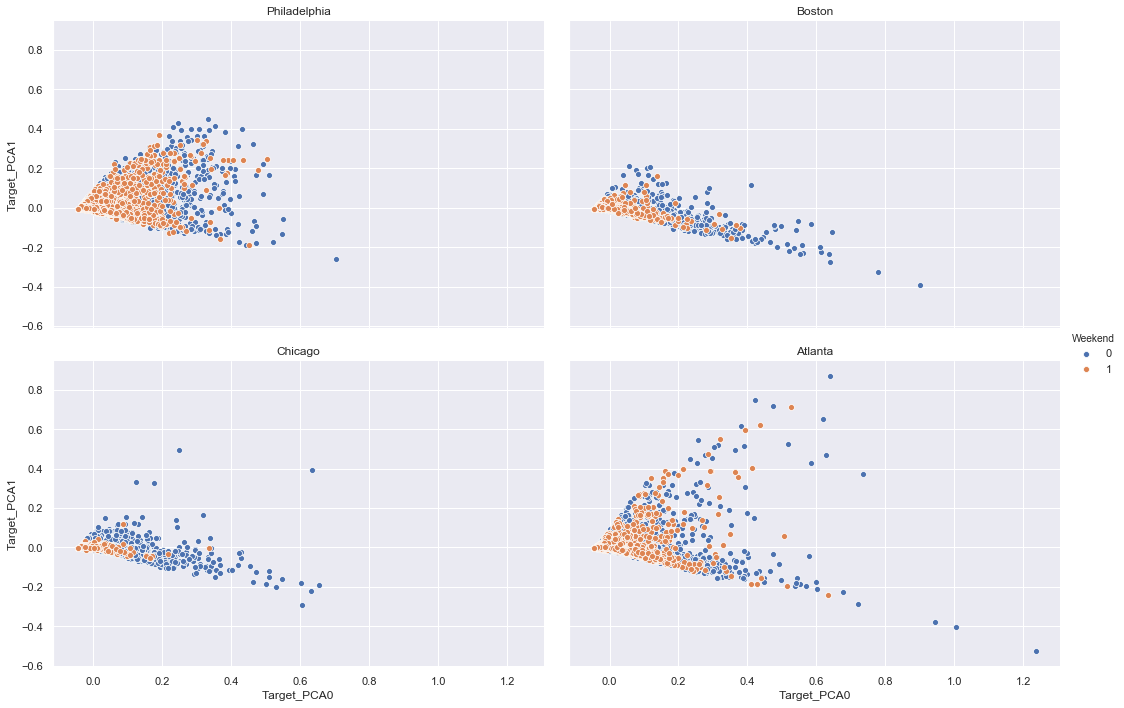

In [26]:
pca.explained_variance_ratio_[:2].sum()

g = sns.FacetGrid(train.sample(50000), col="City", 
                  col_wrap=2, height=5, aspect=1.5, hue='Weekend')

g.map(sns.scatterplot, "Target_PCA0", "Target_PCA1", alpha=1 ).add_legend();
g.set_titles('{col_name}', fontsize=17)
plt.show()

In [27]:
pca.explained_variance_ratio_

array([0.66396904, 0.17536384, 0.07856878])

In [28]:
pca1 = PCA(n_components=6, random_state=5)
pca1.fit_transform(train[min_max_cols])

array([[-0.04441429, -0.00475147, -0.01221791, -0.0027075 , -0.00074564,
        -0.00021381],
       [-0.04441429, -0.00475147, -0.01221791, -0.0027075 , -0.00074564,
        -0.00021381],
       [-0.04441429, -0.00475147, -0.01221791, -0.0027075 , -0.00074564,
        -0.00021381],
       ...,
       [-0.04441429, -0.00475147, -0.01221791, -0.0027075 , -0.00074564,
        -0.00021381],
       [-0.04441429, -0.00475147, -0.01221791, -0.0027075 , -0.00074564,
        -0.00021381],
       [-0.04441429, -0.00475147, -0.01221791, -0.0027075 , -0.00074564,
        -0.00021381]])

In [29]:
print(pca1.explained_variance_ratio_)
print(pca.explained_variance_ratio_)

[0.66396904 0.17536384 0.07856878 0.04090568 0.03011727 0.01107539]
[0.66396904 0.17536384 0.07856878]


In [30]:
print(pca1.explained_variance_ratio_.sum())
print(pca.explained_variance_ratio_)

1.0000000000000002
[0.66396904 0.17536384 0.07856878]


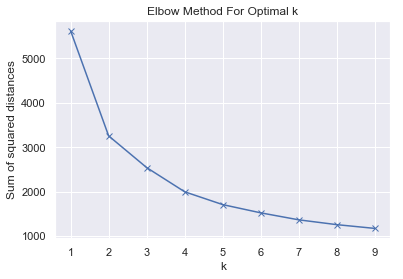

In [31]:
#sum of squared distances
ssd = []

K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=4)
    km = km.fit(train[min_max_cols])
    ssd.append(km.inertia_)
    
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')

plt.show()

<ul>
    <li>elbow method to choose 4 clusters</li>
 </ul>

In [32]:
km = KMeans(n_clusters=4, random_state=4)
km = km.fit(train[min_max_cols])
train['clusters_T'] = km.predict(train[min_max_cols])

In [33]:
pca

PCA(copy=True, iterated_power='auto', n_components=3, random_state=5,
    svd_solver='auto', tol=0.0, whiten=False)

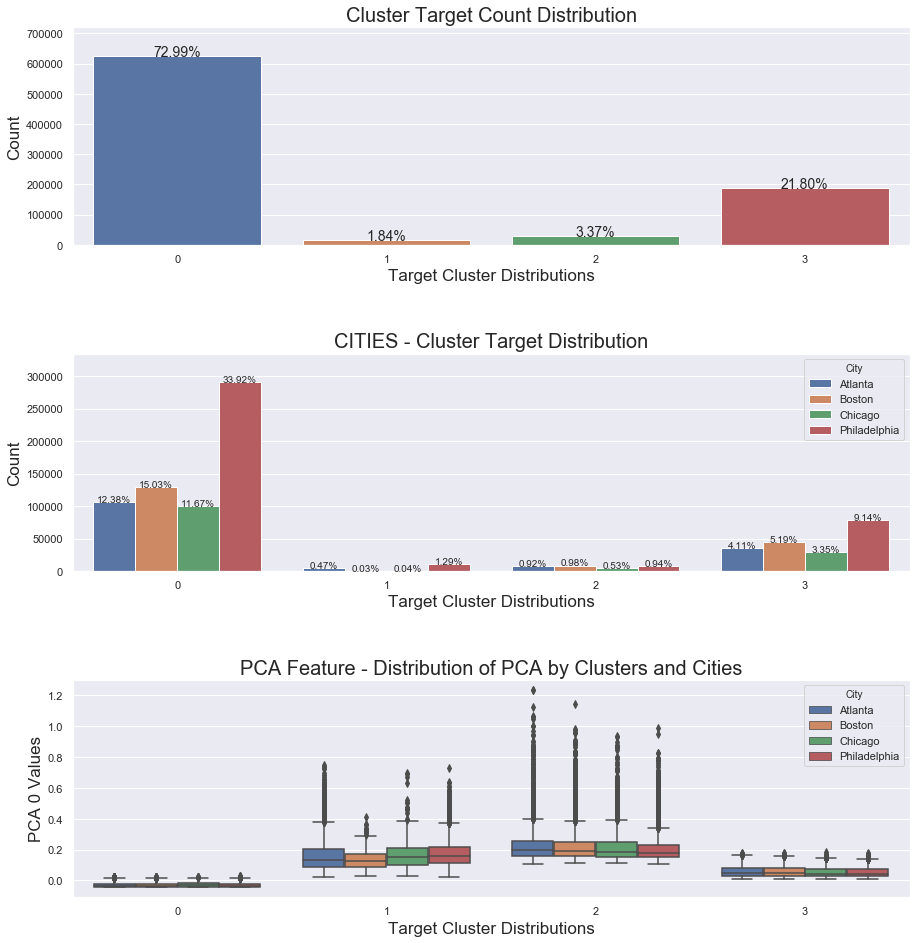

In [34]:
tmp = pd.crosstab(train['City'], train['clusters_T'], 
                  normalize='columns').unstack('City').reset_index().rename(columns={0:"perc"})

total = len(train)
plt.figure(figsize=(15,16))

plt.subplot(311)
g = sns.countplot(x="clusters_T", data=train)
g.set_title("Cluster Target Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Target Cluster Distributions", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(312)
g1 = sns.countplot(x="clusters_T", data=train, hue='City')
g1.set_title("CITIES - Cluster Target Distribution", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Target Cluster Distributions", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10)
g1.set_ylim(0, max(sizes) * 1.15)

plt.subplot(313)
g1 = sns.boxplot(x="clusters_T", y='Target_PCA0', 
                 data=train, hue='City')
g1.set_title("PCA Feature - Distribution of PCA by Clusters and Cities", 
             fontsize=20)
g1.set_ylabel("PCA 0 Values",fontsize= 17)
g1.set_xlabel("Target Cluster Distributions", fontsize=17)

plt.subplots_adjust(hspace = 0.5)

plt.show()

<ul>
    <li>graph 1: count of each cluster, cluster zero and three contain most values</li>
    <li>graph 2: same as graph 1 by city, city distribution consistent accross clusters</li>
    <li>graph 3: <ul>
        <li>clusters graphed against PCA_0, this component explains most variance in target values, so is a good representation of overall scaled target</li>
        <li>cluster 1 appears to be mostly 0s</li>
        <li>cluster 3 appears to be mainlt 0s with a few higher values</li>
        <li>cluster 2 has the most outliers cluster 1 has high values with less outliers</li>
        </ul>
    </li>
        
 </ul>

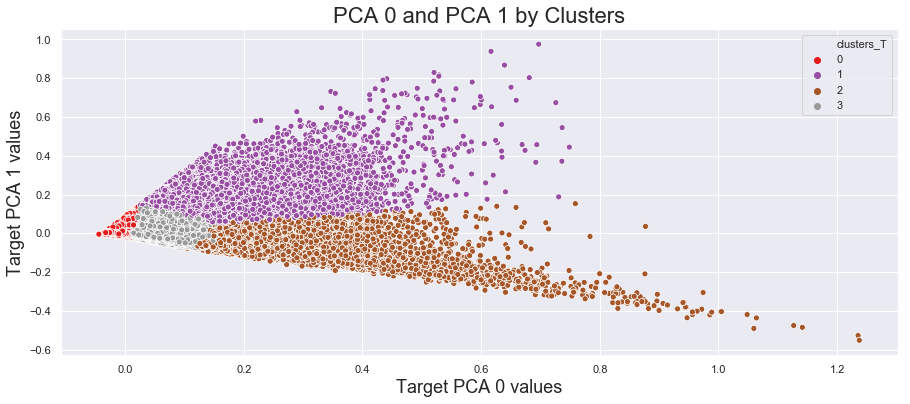

In [35]:
plt.figure(figsize=(15,6))

sns.scatterplot(x='Target_PCA0', y='Target_PCA1',
                hue='clusters_T', data=train,
                palette='Set1')
plt.title("PCA 0 and PCA 1 by Clusters", fontsize=22)
plt.ylabel("Target PCA 1 values", fontsize=18)
plt.xlabel("Target PCA 0 values", fontsize=18)

plt.show()

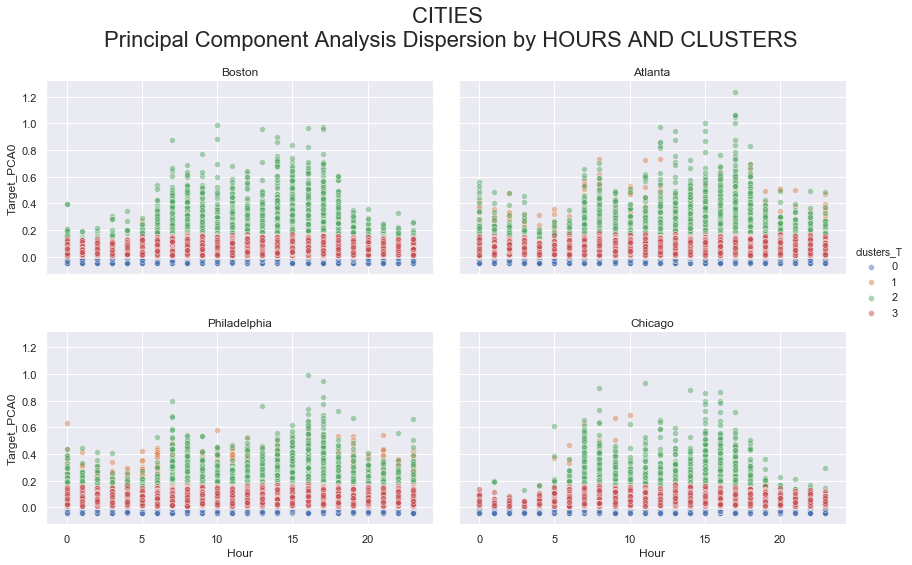

In [36]:
g = sns.FacetGrid(train.sample(500000), col="City", 
                  col_wrap=2, height=4, aspect=1.5, 
                  hue='clusters_T')

g.map(sns.scatterplot, "Hour", "Target_PCA0", 
      alpha=.5).add_legend();
g.set_titles('{col_name}', fontsize=50)

plt.suptitle("CITIES \nPrincipal Component Analysis Dispersion by HOURS AND CLUSTERS", fontsize=22)

plt.subplots_adjust(hspace = 0.3, top=.85)

plt.show()

In [37]:
round(pd.crosstab([train['clusters_T'], train['Weekend']], train['City'],
            normalize='index' ) * 100,0)

City                Atlanta  Boston  Chicago  Philadelphia
clusters_T Weekend                                        
0          0           15.0    22.0     22.0          41.0
           1           22.0    16.0      3.0          59.0
1          0           24.0     2.0      3.0          71.0
           1           30.0     1.0      0.0          69.0
2          0           24.0    32.0     18.0          26.0
           1           43.0    15.0      2.0          41.0
3          0           17.0    26.0     19.0          38.0
           1           27.0    14.0      2.0          56.0

<h1>Feature Engineering</h1>

In [38]:
def date_cyc_enc(df, col, max_vals):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
    return df

train = date_cyc_enc(train, 'Hour', 24)
test = date_cyc_enc(test, 'Hour', 24) 

<ul>
<li>sin and cos transformations transform hour hour data making it cyclical</li>
<li>https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/</li>
</ul>

In [39]:
train['is_day'] = train['Hour'].apply(lambda x: 1 if 7 < x < 18 else 0)
test['is_day'] = test['Hour'].apply(lambda x: 1 if 7 < x < 18 else 0)

train['is_morning'] = train['Hour'].apply(lambda x: 1 if 6 < x < 10 else 0)
test['is_morning'] = test['Hour'].apply(lambda x: 1 if 6 < x < 10 else 0)

train['is_night'] = train['Hour'].apply(lambda x: 1 if 17 < x < 20 else 0)
test['is_night'] = test['Hour'].apply(lambda x: 1 if 17 < x < 20 else 0)

<ul>
<li>categorical variables arbitrarily divided into times of day</li>
</ul>

In [40]:
train['is_day_weekend'] = np.where((train['is_day'] == 1) & (train['Weekend'] == 1), 1,0)
test['is_day_weekend'] = np.where((test['is_day'] == 1) & (train['Weekend'] == 1), 1,0)

train['is_mor_weekend'] = np.where((train['is_morning'] == 1) & (train['Weekend'] == 1), 1,0)
test['is_mor_weekend'] = np.where((test['is_morning'] == 1) & (train['Weekend'] == 1), 1,0)

train['is_nig_weekend'] = np.where((train['is_night'] == 1) & (train['Weekend'] == 1), 1,0)
test['is_nig_weekend'] = np.where((test['is_night'] == 1) & (train['Weekend'] == 1), 1,0)

<ul>
<li>same category splits as above further divided into weekend and not weekend</li>
</ul>

In [41]:
train["Intersec"] = train["IntersectionId"].astype(str) + train["City"]
test["Intersec"] = test["IntersectionId"].astype(str) + test["City"]

print(train["Intersec"].sample(6).values)

['573Philadelphia' '211Boston' '704Philadelphia' '97Atlanta' '28Boston'
 '1829Philadelphia']


<ul>
<li>Concating intersection and city, who tf knows why</li>
</ul>

In [42]:
le = LabelEncoder()

le.fit(pd.concat([train["Intersec"],test["Intersec"]]).drop_duplicates().values)
train["Intersec"] = le.transform(train["Intersec"])
test["Intersec"] = le.transform(test["Intersec"])

<ul>
<li>label encoder makes these numerical</li>
</ul>

In [43]:
#create road encoding
road_encoding = {
    'Road': 1,
    'Street': 2,
    'Avenue': 2,
    'Drive': 3,
    'Broad': 3,
    'Boulevard': 4
}

#encode function
def encode(x):
    if pd.isna(x):
        return 0
    for road in road_encoding.keys():
        if road in x:
            return road_encoding[road]
    return 0

#apply to df
train['EntryType'] = train['EntryStreetName'].apply(encode)
train['ExitType'] = train['ExitStreetName'].apply(encode)
test['EntryType'] = test['EntryStreetName'].apply(encode)
test['ExitType'] = test['ExitStreetName'].apply(encode)

<ul>
<li>arbitrary encoding based on street type</li>
</ul>

In [44]:
#directional encoding
directions = {
    'N': 0,
    'NE': 1/4,
    'E': 1/2,
    'SE': 3/4,
    'S': 1,
    'SW': 5/4,
    'W': 3/2,
    'NW': 7/4
}

#map directional encoding in in train and test
train['EntryHeading'] = train['EntryHeading'].map(directions)
train['ExitHeading'] = train['ExitHeading'].map(directions)
test['EntryHeading'] = test['EntryHeading'].map(directions)
test['ExitHeading'] = test['ExitHeading'].map(directions)

#heading differences will tell us the degree at which you traveled, (0 degrees is straight, 180 u turn)
train['diffHeading'] = train['EntryHeading']-train['ExitHeading']  
test['diffHeading'] = test['EntryHeading']-test['ExitHeading'] 

#if you stay on the same street feature
train["same_str"] = (train["EntryStreetName"] ==  train["ExitStreetName"]).astype(int)
test["same_str"] = (test["EntryStreetName"] ==  test["ExitStreetName"]).astype(int)

<ul><li>assign each direction a numerical value and map to data set</li>
    <li>get the difference between these values to tell us degree of travel (going straight is 0 degrees)</li>
    <li>binary if you say on the same street feature</li></ul>

In [45]:
# Concatenating the city and month into one variable
train['city_month'] = train["City"] + train["Month"].astype(str)
test['city_month'] = test["City"] + test["Month"].astype(str)

monthly_rainfall = {'Atlanta1': 5.02, 'Atlanta5': 3.95, 'Atlanta6': 3.63, 'Atlanta7': 5.12, 
                    'Atlanta8': 3.67, 'Atlanta9': 4.09,'Atlanta10': 3.11, 'Atlanta11': 4.10, 
                    'Atlanta12': 3.82, 'Boston1': 3.92, 'Boston5': 3.24, 'Boston6': 3.22,
                    'Boston7': 3.06, 'Boston8': 3.37, 'Boston9': 3.47, 'Boston10': 3.79,
                    'Boston11': 3.98, 'Boston12': 3.73, 'Chicago1': 1.75, 'Chicago5': 3.38,
                    'Chicago6': 3.63, 'Chicago7': 3.51, 'Chicago8': 4.62, 'Chicago9': 3.27,
                    'Chicago10': 2.71,  'Chicago11': 3.01, 'Chicago12': 2.43, 
                    'Philadelphia1': 3.52, 'Philadelphia5': 3.88, 'Philadelphia6': 3.29,
                    'Philadelphia7': 4.39, 'Philadelphia8': 3.82, 'Philadelphia9':3.88 ,
                    'Philadelphia10': 2.75, 'Philadelphia11': 3.16, 'Philadelphia12': 3.31}

# Creating a new column by mapping the city_month variable to it's corresponding average monthly rainfall
train["average_rainfall"] = train['city_month'].map(monthly_rainfall)
test["average_rainfall"] = test['city_month'].map(monthly_rainfall)

<ul>
<li>arbitrary </li>
</ul>

In [46]:
print(f'Shape before dummy transformation: {train.shape}')
train = pd.get_dummies(train, columns=['City' ],\
                          prefix=['City'], drop_first=False)

print(f'Shape after dummy transformation: {train.shape}')

test = pd.get_dummies(test, columns=['City' ],\
                          prefix=['City'], drop_first=False)

Shape before dummy transformation: (857409, 53)
Shape after dummy transformation: (857409, 56)


<ul>
    <li>3 additional columns added as dummy variables for City</li>
</ul>

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in ['Latitude','Longitude']:
    scaler.fit(train[col].values.reshape(-1, 1))
    train[col] = scaler.transform(train[col].values.reshape(-1, 1))
    test[col] = scaler.transform(test[col].values.reshape(-1, 1))

- reshaping Lat and Long to (-1,1) scales

In [48]:
train.describe()

,RowId,IntersectionId,Latitude,Longitude,EntryHeading,ExitHeading,Hour,Weekend,Month,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,DistanceToFirstStop_p20_minmax,DistanceToFirstStop_p50_minmax,DistanceToFirstStop_p80_minmax,TotalTimeStopped_p20_minmax,TotalTimeStopped_p50_minmax,TotalTimeStopped_p80_minmax,Target_PCA0,Target_PCA1,Target_PCA2,clusters_T,Hour_sin,Hour_cos,is_day,is_morning,is_night,is_day_weekend,is_mor_weekend,is_nig_weekend,Intersec,EntryType,ExitType,diffHeading,same_str,average_rainfall,City_Atlanta,City_Boston,City_Chicago,City_Philadelphia
count,8.574090e+05,857409.000000,8.574090e+05,8.574090e+05,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,8.574090e+05,8.574090e+05,8.574090e+05,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000,857409.000000
mean,2.349039e+06,836.330832,-2.306103e-14,1.297891e-13,0.835693,0.841235,12.427463,0.277485,9.104448,1.731272,5.356027,7.681874,11.905296,22.948071,3.126932,9.051338,12.613628,18.801785,34.037097,6.564450,19.872987,28.255852,43.273503,81.922639,0.003450,0.009116,0.020157,0.006342,0.022396,0.033306,-1.186243e-14,-3.934023e-15,-1.010005e-14,0.739703,-0.065514,-0.203528,0.551966,0.158488,0.085062,0.127084,0.029358,0.027623,3257.463078,1.999378,2.011452,-0.005541,0.695354,3.561753,0.178868,0.212326,0.155905,0.452902
std,2.475128e+05,644.200553,1.000001e+00,1.000001e+00,0.565780,0.568927,6.062097,0.447758,1.993233,7.080017,12.861420,15.553418,19.631821,28.118134,11.631092,20.120829,23.847749,29.399634,40.619387,28.003261,56.564229,71.720090,96.933561,152.682760,0.014718,0.023139,0.037567,0.025934,0.045345,0.040810,6.598482e-02,3.391097e-02,2.269839e-02,1.252091,0.694255,0.687237,0.497292,0.365198,0.278974,0.333067,0.168809,0.163890,1873.894996,0.722723,0.718899,0.430166,0.460257,0.542448,0.383242,0.408954,0.362765,0.497777
min,1.920335e+06,0.000000,-2.056858e+00,-1.662763e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.441429e-02,-5.522245e-01,-5.631815e-01,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.750000,0.000000,2.430000,0.000000,0.000000,0.000000,0.000000
25%,2.134687e+06,306.000000,9.588081e-02,-1.085596e+00,0.500000,0.500000,8.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.441429e-02,-4.751473e-03,-1.221791e-02,0.000000,-0.707107,-0.866025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1552.000000,2.000000,2.000000,0.000000,0.000000,3.160000,0.000000,0.000000,0.000000,0.000000
50%,2.349039e+06,685.000000,1.123868e-01,4.563608e-01,0.750000,1.000000,13.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,60.400000,0.000000,0.000000,0.014861,0.000000,0.000000,0.023222,-2.431689e-02,-4.751473e-03,-2.614303e-03,0.000000,-0.258819,-0.500000,1.00000

In [49]:
train.drop(['RowId', 'Path','EntryStreetName','ExitStreetName'
              ],axis=1, inplace=True)
test.drop(['RowId', 'Path',
              'EntryStreetName','ExitStreetName'],axis=1, inplace=True)

- drop unused/obsolete columns

In [51]:
X = train[['IntersectionId', 'Latitude', 'Longitude', 'EntryHeading',
                    'ExitHeading', 'Hour', 'Weekend', 'Month',
                    'is_morning', 'is_night', 'is_day_weekend', 'is_mor_weekend',
                    'is_nig_weekend', 
                    #'Hour', 
                    'Hour_sin', 
                    'Hour_cos', 
                    'same_str', 'Intersec', 'EntryType',
                    'ExitType', 'diffHeading', 'average_rainfall', 'is_day',
                    'City_Boston', 'City_Chicago', 'City_Philadelphia', 
                    'City_Atlanta']]

y = train[['TotalTimeStopped_p20',
              'TotalTimeStopped_p50', 
              'TotalTimeStopped_p80',
              'DistanceToFirstStop_p20',
              'DistanceToFirstStop_p50',
              'DistanceToFirstStop_p80']]

y1 = train['TotalTimeStopped_p20']
y2 = train['TotalTimeStopped_p50']
y3 = train['TotalTimeStopped_p80']
y4 = train['DistanceToFirstStop_p20']
y5 = train['DistanceToFirstStop_p50']
y6 = train['DistanceToFirstStop_p80']

X_test = test[['IntersectionId', 'Latitude', 'Longitude', 'EntryHeading',
                    'ExitHeading', 'Hour', 'Weekend', 'Month',
                    'is_morning', 'is_night', 'is_day_weekend', 'is_mor_weekend',
                    'is_nig_weekend', 
                    #'Hour', 
                    'Hour_sin', 
                    'Hour_cos', 
                    'same_str', 'Intersec', 'EntryType',
                    'ExitType', 'diffHeading', 'average_rainfall', 'is_day',
                    'City_Boston', 'City_Chicago', 'City_Philadelphia', 
                    'City_Atlanta']]

C:\Users\emag3\Anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\emag3\Anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\emag3\Anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Mem. usage decreased to 68.69 Mb (47.5% reduction)
Mem. usage decreased to 153.84 Mb (47.5% reduction)


- setting X (predictors) and y (predictands)

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

X = reduce_mem_usage(X) 
X_test = reduce_mem_usage(X_test)

- optimizing X (predictors) and y (predictands)

In [55]:
lr = RandomForestRegressor(n_estimators=100,min_samples_split=3)

- (def) hyperparameter: a parameter whose value is set before the learning process
- fitting a number of classifying decision trees on sub-samples of the data

In [57]:
lr.fit(X,y1)
pred1 = lr.predict(X_test)
lr.fit(X,y2)
pred2 = lr.predict(X_test)
lr.fit(X,y3)
pred3 = lr.predict(X_test)
lr.fit(X,y4)
pred4 = lr.predict(X_test)
lr.fit(X,y5)
pred5 = lr.predict(X_test)
lr.fit(X,y6)
pred6 = lr.predict(X_test)

- creating a model and predicting values for each target